In [1]:
import numpy as np
import sys
sys.path.append('./../gp_sinkhorn/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
import matplotlib.pyplot as plt
from MLE_drift import *
import torch

import ot

from celluloid import Camera
from IPython.display import HTML
import math

# Double well

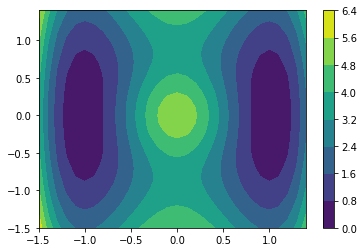

In [2]:
feature_x = np.arange(-1.5, 1.5, 0.1)
feature_y = np.arange(-1.5, 1.5, 0.1)
x, y = np.meshgrid(feature_x, feature_y)

delta = 0.35
fac = 1
z = (5/2.0)*(x**2-1)**2+y**2 +  fac*np.exp(-(  x**2 +y**2)/delta)/delta
 

#  -2 *x/delta*np.exp(-(  x**2 +y**2)/delta)/delta
#  (-( 2*y)/delta )*np.exp(-(  x**2 +y**2)/delta)/delta

h = plt.contourf(feature_x,feature_y,z)
plt.colorbar()
plt.show()



In [3]:
np.where(z.max() ==z)

(array([0], dtype=int64), array([0], dtype=int64))

In [6]:
z[10,10]

2.340967246976508

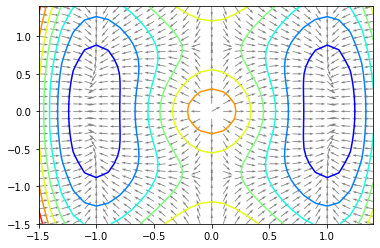

In [7]:
u = -(10*x*(x**2-1)) + fac* 2 * x * np.exp(-(  x**2 +y**2)/delta)/delta**2
v = -(2*y)  + fac * 2* y * np.exp(-(  x**2 +y**2)/delta)/delta**2

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.1
v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [8]:
delta_tn = torch.tensor(delta)

deriv_x = lambda x,y: -(10*x*(x**2-1)) +  2 * x * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
deriv_y = lambda x,y: -(2*y) +2* y * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
# deriv_y = deriv_x
# prior_drift = lambda X: torch.tensor([[deriv_x(i[0]),deriv_y(i[1])] for i in X])

prior_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

In [9]:
num_samples=50
sigma = 0.5
dt = 0.02
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))

mu_2 = torch.tensor([0.0,0.0])
X_2 = torch.distributions.multivariate_normal.MultivariateNormal(mu_2,torch.eye(2)*0.5).sample((150,1)).reshape((-1,2))

prior_X_0 = X_2

t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=prior_X_0, dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

In [150]:
import scipy
import numpy
def interpolate_with_ot(p0, p1, tmap, interp_frac, size):
    """
    Interpolate between p0 and p1 at fraction t_interpolate knowing a transport map from p0 to p1
    Parameters
    ----------
    p0 : 2-D array
        The genes of each cell in the source population
    p1 : 2-D array
        The genes of each cell in the destination population
    tmap : 2-D array
        A transport map from p0 to p1
    t_interpolate : float
        The fraction at which to interpolate
    size : int
        The number of cells in the interpolated population
    Returns
    -------
    p05 : 2-D array
        An interpolated population of 'size' cells
    """
    p0 = p0.toarray() if scipy.sparse.isspmatrix(p0) else p0
    p1 = p1.toarray() if scipy.sparse.isspmatrix(p1) else p1
    p0 = np.asarray(p0, dtype=np.float64)
    p1 = np.asarray(p1, dtype=np.float64)
    tmap = np.asarray(tmap, dtype=np.float64)
    if p0.shape[1] != p1.shape[1]:
        raise ValueError("Unable to interpolate. Number of genes do not match")
    if p0.shape[0] != tmap.shape[0] or p1.shape[0] != tmap.shape[1]:
        raise ValueError(
            "Unable to interpolate. Tmap size is {}, expected {}".format(
                tmap.shape, (len(p0), len(p1))
            )
        )
    I = len(p0)
    J = len(p1)
    # Assume growth is exponential and retrieve growth rate at t_interpolate
    # If all sums are the same then this does not change anything
    # This only matters if sum is not the same for all rows
    p = tmap
    p = p.flatten(order="C")
    p = p / p.sum()
    choices = np.random.choice(I * J, p=p, size=size)
    return np.asarray(
        [p0[i // J] * (1 - interp_frac) + p1[i % J] * interp_frac for i in choices],
        dtype=np.float64,
    )


def knn_log_prob(xTest, xTrain, k=3, w=0):
    """
    Can use this as an alternative to  log_kde_pdf_per_point, very noisy
    
    Approximate density p(x) ~ 1/kNN(x, {y_i})^d 
    the ln p(x) ~ - d * log kNN(x, {y_i})
    
    where kNN(x, {y_i}) is the distance of the kth nearest neighbour
    
    source: http://faculty.washington.edu/yenchic/18W_425/Lec7_knn_basis.pdf
    
    loss is very noisy, and goes down very slowly and un-monotnically
    
    Theres a lot of studies about these estimates for KL and entropy by Barnabas Poczos
    they might have refinements on the kNNN part. 
    
    w is a windowing parameter to take the mean of the kNN distance going backwards
    to the k-w nearest neighbours, to make things less noisy.    
    """
    k = int(k)
    w = int(min(w, k ))
    xTest, xTrain = xTest.double(), xTrain.double()
    n, d = xTrain.shape
#     import pdb; pdb.set_trace()
    sq_distances = -2.0 * torch.mm(xTrain, xTest.T) + torch.sum(xTest**2,axis=1) + torch.sum(xTrain**2,axis=1)[:, None]
#     import pdb; pdb.set_trace()
    sq_distances = torch.clamp(sq_distances, 0, None)
    sq_distances, _ =  torch.sort(sq_distances,0) #distances sorted in axis 0
#     sq_distance = torch.mean(sq_distances[ k,:])
    sq_distance = sq_distances[ k,:]
#     print(sq_distance)
#     import pdb; pdb.set_trace()
    return -(d * 0.5 * torch.log(sq_distance)).float()


def sinkhorn_cost_estimate(X,Y, prior_drift_, sigma=1, N=54,  kernel_samples=20):
    
    n, m = X.shape[0], Y.shape[0]
    M = torch.zeros((n, m))
    
    dt = 1.0 /N
    for i in tqdm(range(n)):
        X_i = X[i,:].reshape(1,-1).repeat(kernel_samples, 1)

        t, Xts = solve_sde_RK(b_drift=prior_drift_,sigma=sigma, X0=X_i, dt=dt, N=N)
        Ys = Xts[:,-1,:-1]
    #     import pdb; pdb.set_trace()
        cost = -knn_log_prob(Y, Ys)
        M[i,:] = cost 
    return M


def sinkhorn_with_prior(X,Y, prior_drift_, sigma=1, N=54, kernel_samples=20):
    if prior_drift_ is None:
        prior_drift_ = lambda x: 0
    n, m = X.shape[0], Y.shape[0]
    
    a, b = np.ones(n,)/n, np.ones(m,)/m
    
    M = sigma**2 * sinkhorn_cost_estimate(X, Y, prior_drift_, sigma).detach().numpy()
#     M = M = ot.dist(X, Y)
#     M /= M.max()
    plt.imshow(M, interpolation='nearest')
#     import pdb; pdb.set_trace()
    T = ot.sinkhorn(a,b ,M, numItermax=1e7, reg=sigma**2)
    
    return T, M


# def evaluate_sinkhorn_potential(Xnew, T, X,Y, sigma=1):
    

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.31it/s]


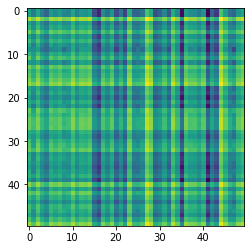

In [151]:
T, M = sinkhorn_with_prior(X_0, X_1, prior_drift_=None, N=N, sigma=0.1)

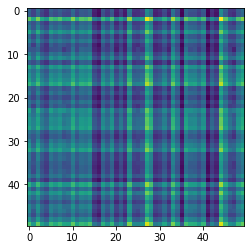

In [143]:
plt.imshow(M, interpolation='nearest')

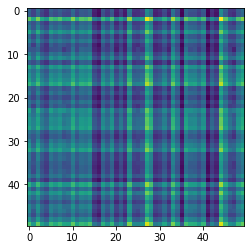

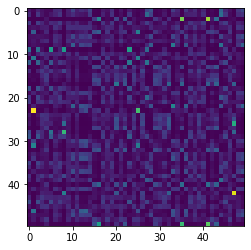

In [137]:
plt.imshow(T, interpolation='nearest')

In [138]:
import ot.plot

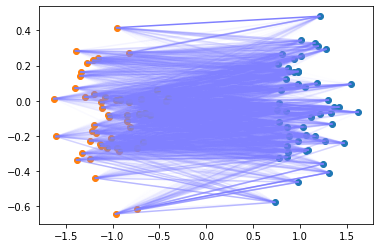

In [142]:
ot.plot.plot2D_samples_mat(X_0, X_1, T, c=[.5, .5, 1])
plt.scatter(X_0[:,0],X_0[:,1])

plt.scatter(X_1[:,0],X_1[:,1])

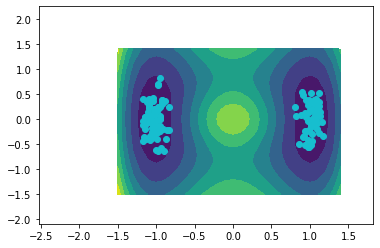

In [8]:
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')



In [9]:
N

50

In [17]:
# sparse enables the nystrom method which is just a low rank approximation of the kernel matrix using
# random subsampling, should not affect interpretability much, ive tested it in all our experiments
# works surprisingly well

sigma= 2 # Works at 1.5 breaks at 0.5, what to do ?
sigma_target = 0.15

mod = 1
iteration = 25

increments = int(iteration / mod)
#  sigma_target =  sigma * decay_sigma**iteration 
decay_sigma = (sigma_target/sigma)**(1.0/increments)

sigma_test = sigma
for i in range(increments):
    sigma_test *= decay_sigma
    print(sigma_test)


1.8031524495915348
1.6256793782339762
1.4656738765565187
1.3214167204076037
1.1913578981670914
1.0740999562101066
0.968382983573207
0.8730710744863935
0.7871401233138269
0.7096668207625548
0.6398187331259186
0.5768453579652764
0.5200700601252969
0.4688828014370729
0.42273358599129957
0.38112655055241274
0.34361463661647745
0.3097947868652532
0.27930361440338436
0.251813498245616
0.22702906310089807
0.20468400562942773
0.18453823307145506
0.16637528350304387
0.1499999999999998


In [18]:
decay_sigma

0.9015762247957674

In [19]:

result = MLE_IPFP(
    X_0,X_1,N=N,sigma=sigma,
    prior_drift=prior_drift, sparse=False, 
    prior_X_0=prior_X_0, iteration=iteration, refinement_iterations=0,
    decay_sigma=decay_sigma, gp_mean_prior_flag=True
)


Log dir not found


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [2:32:42<00:00, 366.50s/it]


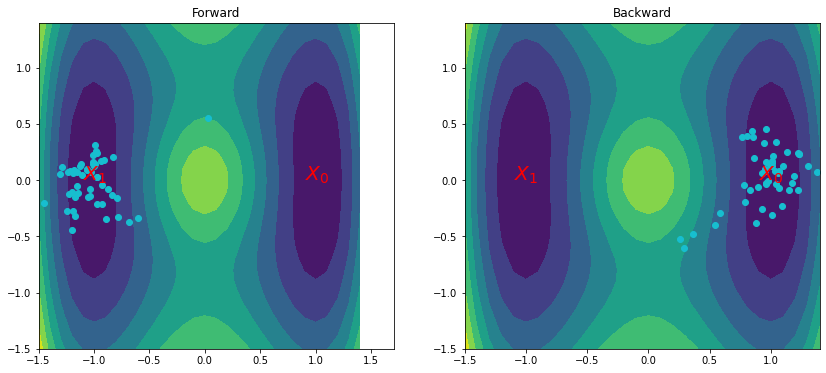

In [20]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

Text(-1.1, 0, '$X_1$')

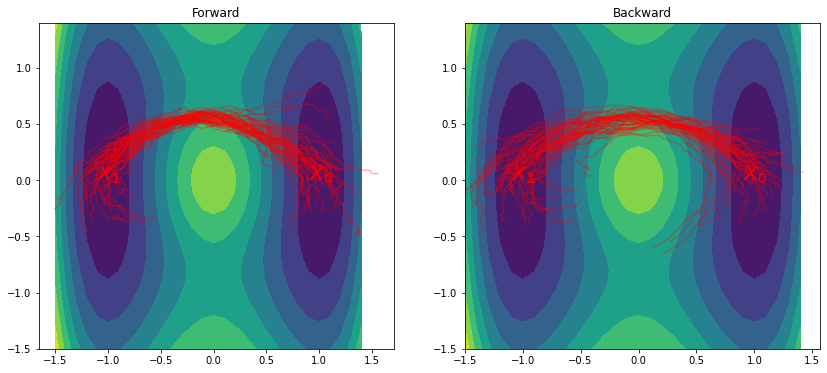

In [24]:
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))

M = result[-1][1]
M2 = result[-1][3]
for i in range(len(M)): 
   
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)

    μ10 = M[i,:,0].detach()#.mean(axis=0)
    μ11 = M[i,:,1].detach()#.mean(axis=0)
#     σ10 = M[i,:,0].detach().std(axis=0)
#     σ11 = M[i,:,1].detach().std(axis=0)

    μ20 = M2[i,:,0].detach()#.mean(axis=0)
    μ21 = M2[i,:,1].detach()#.mean(axis=0)
#     σ20 = M2[i,:,0].detach().std(axis=0)
#     σ21 = M2[i,:,1].detach().std(axis=0)

    ax1.plot(μ10, μ11, alpha=.3, color="red")
    ax2.plot(μ20, μ21, alpha=.3, color="red")

# ax1.plot(μ10, μ11 + 2*σ11)

# ax1.fill_between( μ11-2*σ11, μ11+2*σ11, alpha=.5)

# ax2.fill_between(μ20-2*σ20, μ21+2*σ21, alpha=.5)



ax1.set_title("Forward")
ax2.set_title("Backward")

ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')


In [22]:
import pandas as pd

pd.to_pickle(result, "nice_well_trajectory_20_iters_both_prior.pkl")

In [23]:
result_=pd.read_pickle("nice_well_trajectory_20_iters_both_prior.pkl")